# Módulo 9:  Métricas de evaluación de modelos

## 1. Introducción

El objetivo de esta práctica es analizar en la práctica las medidas de evaluación para modelos de clasificación mencionadas.

Para ello trabajaremos tratando de predecir la probabilidad de que un empleado deje la empresa. Para ello se dispone de un dataset 

Los campos incluidos son:

1. Última evaluación
2. Cantidad de proyectos en los que trabajó
3. Promedio de horas mensuales trabajadas
4. Tiempo en la compañía
5. Sufrió un accidente de trabajo
6. Tuvo una promoción en el último año
7. Nivel salarial

El objetivo, entonces, es predecir la probabilidad de que $P(left=1 | X)$ 

## 2. Métricas de evaluación para problemas de clasificación

Como de costumbre, importamos los datos y el dataset

In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, roc_curve, auc, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('HR_comma_sep.csv')
df.sample(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
2216,0.97,0.60,3,162,3,0,0,0,technical,medium
14756,0.78,1.00,5,236,5,0,1,0,sales,medium
5659,0.93,0.82,5,272,3,0,0,0,sales,high
14524,0.41,0.49,2,130,3,0,1,0,marketing,low
13725,0.39,0.52,2,102,8,0,0,0,technical,medium
10252,0.32,0.81,5,111,4,0,0,0,sales,medium
6710,0.49,0.91,5,231,3,0,0,0,RandD,medium
2093,0.58,0.90,3,212,3,0,0,0,hr,medium
3177,0.57,0.82,5,218,3,0,0,0,support,medium
1116,0.09,0.85,6,260,4,0,1,0,support,medium


Armamos la matriz de predictores ($X$) y el target ($y$)

In [3]:
train_cols = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 
              'time_spend_company', 'Work_accident', 'promotion_last_5years']
X = df[train_cols]
y = df['left']

Hacemos el split entre train y test:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### 2.1 Entrenando un primer clasificador

Como primer paso (y para mantener el problema simple) comencemos entrenando una regresión logística.

In [5]:
clf = LogisticRegression(C=1e10)
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,10000000000.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [6]:
y_pred = clf.predict(X_test)

### 2.2 Métricas: Accuracy

Como recordarán, el accuracy se calcula como la proporción samples correctamente clasificados sobre el total de samples.

In [7]:
from sklearn.metrics import accuracy_score
print('Accuracy=', accuracy_score(y_test, y_pred))

Accuracy= 0.7555555555555555


Es decir, que en este caso, encontramos que el 76% delos casos -en el test set- han sido correctamente clasificados.

Ahora bien, ¿qué tan bueno es este clasificador? ¿Qué significa que podamos clasificar correctamente a esta proporción de casos?

Una primera forma de comenzar a responder esta pregunta es comparar la performance con un clasificador bien simple y (casi) trivial: se lo suele llamar "clasificador nulo" y consiste simplemente en predecir solamente teniendo en cuenta la clase más frecuente.

In [8]:
y_test.value_counts()

left
0    3769
1    1181
Name: count, dtype: int64

In [9]:
y_test.mean()

np.float64(0.2385858585858586)

Es decir que 23% de los casos en el train-set son 1, es decir, se irán de la empresa. Por ende, la proporción de 0 (es decir, casos que no se van de la empresa) será:

In [10]:
1.0 - y_test.mean()

np.float64(0.7614141414141414)

Nuestro modelo simple, entonces, haría predicciones siempre igual a cero. Si realizáramos las predicciones en función de este dato... ¿qué accuracy esperaríamos obtener...? En efecto, esperaríamos obtener una accuracy cercana al 76%. Es decir, esperaríamos estar en lo correcto (sin ninguna otra informacion) en un 76% de los casos.

De esta forma, pareciera que el modelo de regresión logística no es tan bueno: no parece mejorar demasiado respecto al modelo simple. Si solamente consideráramos el accuracy podríamos habernos equivocado en la evaluación de nuestro modelo. Por eso suele ser útil considerar otras métricas de evaluación. 

### 2.3 Métricas: Confusion Matrix

Para poder entender que tan bien funciona nuestro clasificador podemos graficar la mátriz de confusión.

Básicamente, es una tabla de contingencia que tabula la distribución de los casos analizados en función de su valor real ("observado") y su valor estimado por el modelo ("predicho"). 

En `confusion_matrix` es importante recordar que el primer arugmento corresponde a los valores observados y el segundo a los valores predichos:

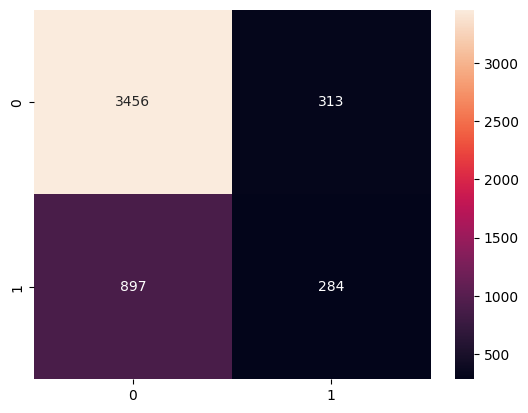

In [11]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion,annot=True,fmt='g')
plt.show()

* **True Positives (TP):** hemos predicho correctamente que el empleado se va (284)
* **True Negatives (TN):** hemos predicho correctamente que el empleado se queda (3459)
* **False Positives (FP):** hemos predicho que el empleado se iba pero se queda (310)
* **False Negatives (FN):** hemos predicho que el empleado se queda pero se va (897)

Asignemos a variables estos casos para realizar algunos cálculos:

### 2.4 Métricas computadas desde la matriz de confusión: <font color='red'>Sensitivity (o recall)</font>

Mide la capacidad (qué tan "sensible" es) del modelo de detectar los verdaderos positivos (TP) sobre todos los casos que son positivos (FN + TP). En nuestro ejemplo: del total de personas que se van, ¿cuántas logra clasificar correctamente el modelo?

In [12]:
from sklearn.metrics import recall_score
print(recall_score(y_test, y_pred))

0.24047417442845045


### 2.5 Métricas computadas desde la matriz de confusión: <font color='red'>Precision</font> 

Mide qué tan "preciso" es el clasificador al predecir las instancias positivas. Es decir, cuando el clasificador predice un valor positivo... ¿qué tan frecuentemente es esta predicción correcta?

In [13]:
from sklearn.metrics import precision_score
print(precision_score(y_test, y_pred))

0.47571189279731996


### 2.6 Métricas computadas desde la matriz de confusión: <font color='red'>F1-Score</font> 

Es un promedio armónimo entre precision y recall.

In [14]:
from sklearn.metrics import f1_score
print(f1_score(y_test,y_pred))

0.3194600674915636


## 3. Curvas ROC y área bajo la curva (AUC)

Muy útil si queremos visualizar cómo se mueven sensitivity y specificity ante diversos umbrales. 

La curva ROC se basa en $TPR$ (tasa de verdaderos positivos) y $FPR$ (tasa de falsos negativos).

* Definamos las metricas de True Positive Ratio y False Positive Rate y se las asignamos las los valores predichos vs los valores de test (observados vs esperados).
* El método `roc_curve` toma como parámetros dos valores: los valores observados del target y un array de probabilidades (NO recibe las predicciones de la clase).
* Devuelve tres elementos en forma de arrays: la tasa de falsos positivos ($FPR$), la tasa de verdaderos positivos ($TPR$) y los umbrales

In [15]:
preds_prob = clf.predict_proba(X_test)

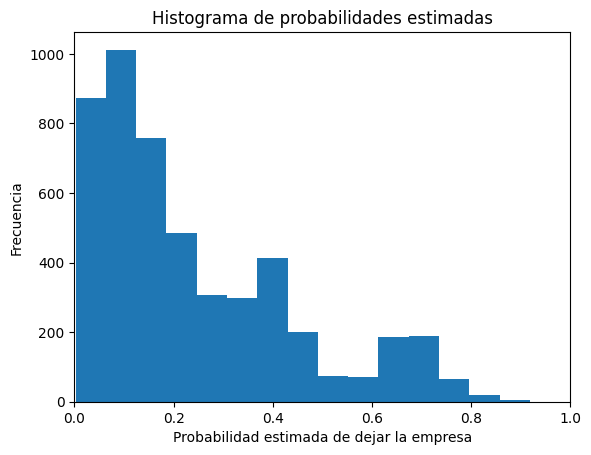

In [16]:
# 15 bins
preds_left = preds_prob[:,1]
plt.hist(preds_left, bins=15)

# x-axis de 0 a 1
plt.xlim(0,1)
plt.title('Histograma de probabilidades estimadas')
plt.xlabel('Probabilidad estimada de dejar la empresa')
plt.ylabel('Frecuencia')
plt.show()

In [17]:
fpr,tpr,_ = roc_curve(y_test, preds_prob[:,1])

* Convertimos los valores en un objeto dataframe y graficamos la curva ROC

In [18]:
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))

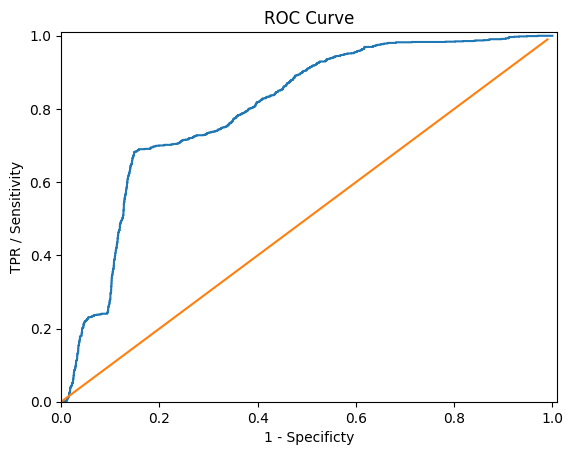

In [19]:
plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show() 

* Calculamos el área bajo la curva ROC

In [20]:
print('AUC=', auc(fpr, tpr))

AUC= 0.7991404094501492


## 4. Cross Validation (validación cruzada) con otras métricas

Supongamos que queremos estimar el error de generalización de nuestro modelo de regresión pero usando cross-validation. Podemos usar la función `cross_val_score` cambiando la métrica a evaluar:

In [21]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold

kf = KFold(n_splits=10, shuffle = True)

print('F1-CV=', np.mean(cross_val_score(clf, X, y, cv=kf, scoring='f1')))
print('Recall-CV=', np.mean(cross_val_score(clf, X, y, cv=kf, scoring='recall')))
print('Precision-CV=', np.mean(cross_val_score(clf, X, y, cv=kf, scoring='precision')))

F1-CV= 0.33921538197382545
Recall-CV= 0.25094280033247357
Precision-CV= 0.5150147420580587


Al utilizar Cross Validation (cross_val_score) somos capaces de utilizar todo el dataset tanto para entrenar, como para predecir, y así evitar la aparición de sesgos. 